In [55]:
%pip install h5py rtree pygeos pip --upgrade

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [56]:
import pandas as pd
import numpy as np
import seaborn as sns

import h5py

import geopandas as gpd
import geobr

from datetime import datetime

from shapely.geometry import Point

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors
import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap

In [57]:
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams['axes.grid'] = False
plt.rcParams['font.size'] = '10'

In [58]:
file_path = './1 - Organized data gauge/BRAZIL/DATASETS/BRAZIL_DAILY_1961_2024_CLEANED.h5'
with h5py.File(file_path, 'r') as hdf:
    keys = list(hdf.keys())
    print(keys)

['table_data', 'table_data_filtered', 'table_info', 'table_metrics', 'table_p_availability', 'table_preclassif', 'table_q1_gaps', 'table_q2_week', 'table_q3_outliers', 'table_qc_info']


# Data processing

In [59]:
df_info = pd.read_hdf(file_path, key = 'table_info', encoding = 'utf-8')
df_info

,name_station,gauge_code,city,state,responsible,source,state_abbreviation,lat,long
18981,SELVIRIA | S717,S717,SELVIRIA,MATO GROSSO DO SUL,INMET,INMET,MS,-20.351389,-51.430278
18980,SANTA RITA DO PARDO | S716,S716,SANTA RITA DO PARDO,MATO GROSSO DO SUL,INMET,INMET,MS,-21.305889,-52.820375
18979,RIBAS DO RIO PARDO | S715,S715,RIBAS DO RIO PARDO,MATO GROSSO DO SUL,INMET,INMET,MS,-20.466694,-53.763028
18978,PEDRO GOMES | S714,S714,PEDRO GOMES,MATO GROSSO DO SUL,INMET,INMET,MS,-18.072778,-54.548889
18977,NOVA ANDRADINA | S713,S713,NOVA ANDRADINA,MATO GROSSO DO SUL,INMET,INMET,MS,-22.078611,-53.465833
...,...,...,...,...,...,...,...,...,...
4,MARUDA,00047005,MARAPANIM,PARÁ,ANA,HIDROWEB,PA,-0.633600,-47.658300
3,PRIMAVERA,00047004,PRIMAVERA,PARÁ,ANA,HIDROWEB,PA,-0.929400,-47.099400
2,CURUÇA,00047003,CURUÇA,PARÁ,ANA,HIDROWEB,PA,-0.737500,-47.853600
1,SALINÓPOLIS,00047002,SALINÓPOLIS,PARÁ,ANA,HIDROWEB,PA,-0.623100,-47.353600


In [60]:
source_counts = df_info.groupby('source').size().reset_index(name='count')
source_counts

,source,count
0,CEMADEN,3860
1,HIDROWEB,11128
2,INMET,827
3,TELEMETRIA,2555


In [61]:
df_data = pd.read_hdf(file_path, key = 'table_data', encoding = 'utf-8')
df_data = pd.merge(df_data, df_info[['gauge_code']], on = 'gauge_code', how = 'inner')
df_data

,gauge_code,datetime,rain_mm
0,00047000,1961-01-01,0.0
1,00047000,1961-01-02,0.0
2,00047000,1961-01-03,0.0
3,00047000,1961-01-04,0.0
4,00047000,1961-01-05,0.0
...,...,...,...
123596316,S717,2021-12-27,0.0
123596317,S717,2021-12-28,0.0
123596318,S717,2021-12-29,0.0
123596319,S717,2021-12-30,0.0


In [62]:
gauge_set = set((df_data['gauge_code'].unique()))
len(gauge_set)

18370

In [63]:
def analyze_gauge_activity(df):
    # Ensure datetime is in datetime format
    df['datetime'] = pd.to_datetime(df['datetime'])

    # Group by gauge_code
    grouped = df.groupby('gauge_code')
    
    # Initialize lists to store results
    gauge_codes = []
    num_years_activity = []
    first_dates = []
    last_dates = []
    years_without_gaps = []
    percent_missing_days = []
    percent_years_with_missing_days = []
    
    for gauge_code, group in grouped:
        gauge_codes.append(gauge_code)
        
        # Calculate number of years with activity
        years = group['datetime'].dt.year.unique()
        num_years_activity.append(len(years))
        
        # Calculate first and last date
        first_dates.append(group['datetime'].min())
        last_dates.append(group['datetime'].max())
        
        # Calculate years without gaps
        complete_years = group.set_index('datetime').resample('YE').count()
        complete_years = complete_years[complete_years['rain_mm'] >= 365]
        years_without_gaps.append(len(complete_years))
        
        # Calculate percent of missing days
        total_days = (group['datetime'].max() - group['datetime'].min()).days + 1
        missing_days = total_days - len(group)
        percent_missing_days.append((missing_days / total_days) * 100)
        
        # Calculate percent of years with missing days
        years_with_missing_days = len(years) - len(complete_years)
        percent_years_with_missing_days.append((years_with_missing_days / len(years)) * 100)
    
    # Create result dataframe
    result_df = pd.DataFrame({
        'gauge_code': gauge_codes,
        'num_years_activity': num_years_activity,
        'first_date': first_dates,
        'last_date': last_dates,
        'years_without_gaps': years_without_gaps,
        'percent_missing_days': percent_missing_days,
        'percent_years_with_missing_days': percent_years_with_missing_days
    })
    
    return result_df

# Example usage
df_gauge_analysis = analyze_gauge_activity(df_data)
df_gauge_analysis

,gauge_code,num_years_activity,first_date,last_date,years_without_gaps,percent_missing_days,percent_years_with_missing_days
0,00047000,4,1961-01-01,1964-12-31,4,0.0,0.000000
1,00047002,44,1977-12-09,2020-12-31,43,0.0,2.272727
2,00047003,40,1981-07-01,2020-12-31,39,0.0,2.500000
3,00047004,39,1982-02-18,2020-12-31,38,0.0,2.564103
4,00047005,32,1989-08-21,2020-12-31,31,0.0,3.125000
...,...,...,...,...,...,...,...
18365,S713,1,2021-01-01,2021-12-31,1,0.0,0.000000
18366,S714,1,2021-01-01,2021-12-31,1,0.0,0.000000
18367,S715,1,2021-01-01,2021-12-31,1,0.0,0.000000
18368,S716,1,2021-01-01,2021-12-31,1,0.0,0.000000


In [64]:
df_gauge_analysis.to_hdf(file_path, key = 'table_metrics', mode = 'r+', complevel = 9, encoding="utf-8")
df_gauge_analysis

,gauge_code,num_years_activity,first_date,last_date,years_without_gaps,percent_missing_days,percent_years_with_missing_days
0,00047000,4,1961-01-01,1964-12-31,4,0.0,0.000000
1,00047002,44,1977-12-09,2020-12-31,43,0.0,2.272727
2,00047003,40,1981-07-01,2020-12-31,39,0.0,2.500000
3,00047004,39,1982-02-18,2020-12-31,38,0.0,2.564103
4,00047005,32,1989-08-21,2020-12-31,31,0.0,3.125000
...,...,...,...,...,...,...,...
18365,S713,1,2021-01-01,2021-12-31,1,0.0,0.000000
18366,S714,1,2021-01-01,2021-12-31,1,0.0,0.000000
18367,S715,1,2021-01-01,2021-12-31,1,0.0,0.000000
18368,S716,1,2021-01-01,2021-12-31,1,0.0,0.000000


In [65]:
df_gauge_analysis = pd.read_hdf(file_path, key = 'table_metrics', encoding = 'utf-8')

In [66]:
df_lat_long = df_info[df_info['gauge_code'].isin(df_data['gauge_code'].unique())]

df_lat_long[['gauge_code',	'lat',	'long']].to_excel('./5 - Results/df_lat_long.xlsx', index = False, sheet_name='data')

In [67]:
df_complete_info = pd.merge(df_info, df_gauge_analysis, on='gauge_code', how = 'inner')
df_complete_info

,name_station,gauge_code,city,state,responsible,source,state_abbreviation,lat,long,num_years_activity,first_date,last_date,years_without_gaps,percent_missing_days,percent_years_with_missing_days
0,SELVIRIA | S717,S717,SELVIRIA,MATO GROSSO DO SUL,INMET,INMET,MS,-20.351389,-51.430278,1,2021-01-01,2021-12-31,1,0.0,0.000000
1,SANTA RITA DO PARDO | S716,S716,SANTA RITA DO PARDO,MATO GROSSO DO SUL,INMET,INMET,MS,-21.305889,-52.820375,1,2021-01-01,2021-12-31,1,0.0,0.000000
2,RIBAS DO RIO PARDO | S715,S715,RIBAS DO RIO PARDO,MATO GROSSO DO SUL,INMET,INMET,MS,-20.466694,-53.763028,1,2021-01-01,2021-12-31,1,0.0,0.000000
3,PEDRO GOMES | S714,S714,PEDRO GOMES,MATO GROSSO DO SUL,INMET,INMET,MS,-18.072778,-54.548889,1,2021-01-01,2021-12-31,1,0.0,0.000000
4,NOVA ANDRADINA | S713,S713,NOVA ANDRADINA,MATO GROSSO DO SUL,INMET,INMET,MS,-22.078611,-53.465833,1,2021-01-01,2021-12-31,1,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18365,MARUDA,00047005,MARAPANIM,PARÁ,ANA,HIDROWEB,PA,-0.633600,-47.658300,32,1989-08-21,2020-12-31,31,0.0,3.125000
18366,PRIMAVERA,00047004,PRIMAVERA,PARÁ,ANA,HIDROWEB,PA,-0.929400,-47.099400,39,1982-02-18,2020-12-31,38,0.0,2.564103
18367,CURUÇA,00047003,CURUÇA,PARÁ,ANA,HIDROWEB,PA,-0.737500,-47.853600,40,1981-07-01,2020-12-31,39,0.0,2.500000
18368,SALINÓPOLIS,00047002,SALINÓPOLIS,PARÁ,ANA,HIDROWEB,PA,-0.623100,-47.353600,44,1977-12-09,2020-12-31,43,0.0,2.272727


In [68]:
def analyze_gauge_activity_by_year(df):
    # Ensure datetime is in datetime format
    df['datetime'] = pd.to_datetime(df['datetime'])

    # Group by gauge_code and year
    df['year'] = df['datetime'].dt.year
    grouped = df.groupby(['gauge_code', 'year'])
    
    # Initialize lists to store results
    gauge_codes = []
    years = []
    num_days_activity = []
    first_dates = []
    last_dates = []
    percent_missing_days = []
    
    for (gauge_code, year), group in grouped:
        gauge_codes.append(gauge_code)
        years.append(year)
        
        # Calculate number of days with activity
        num_days_activity.append(len(group))
        
        # Calculate first and last date
        first_dates.append(group['datetime'].min())
        last_dates.append(group['datetime'].max())
        
        # Calculate percent of missing days
        total_days = (datetime(year, 12, 31) - datetime(year, 1, 1)).days + 1
        missing_days = total_days - len(group)
        percent_missing_days.append((missing_days / total_days) * 100)
    
    # Create result dataframe
    result_df = pd.DataFrame({
        'gauge_code': gauge_codes,
        'year': years,
        'num_days_activity': num_days_activity,
        'first_date': first_dates,
        'last_date': last_dates,
        'percent_missing_days': percent_missing_days
    })
    
    return result_df

# Example usage
df_gauge_analysis_by_year = analyze_gauge_activity_by_year(df_data)
df_gauge_analysis_by_year

,gauge_code,year,num_days_activity,first_date,last_date,percent_missing_days
0,00047000,1961,365,1961-01-01,1961-12-31,0.00000
1,00047000,1962,365,1962-01-01,1962-12-31,0.00000
2,00047000,1963,365,1963-01-01,1963-12-31,0.00000
3,00047000,1964,366,1964-01-01,1964-12-31,0.00000
4,00047002,1977,23,1977-12-09,1977-12-31,93.69863
...,...,...,...,...,...,...
345863,S713,2021,365,2021-01-01,2021-12-31,0.00000
345864,S714,2021,365,2021-01-01,2021-12-31,0.00000
345865,S715,2021,365,2021-01-01,2021-12-31,0.00000
345866,S716,2021,365,2021-01-01,2021-12-31,0.00000


In [69]:
df_complete_info_by_year = pd.merge(df_info,df_gauge_analysis_by_year, on='gauge_code')
df_complete_info_by_year

,name_station,gauge_code,city,state,responsible,source,state_abbreviation,lat,long,year,num_days_activity,first_date,last_date,percent_missing_days
0,SELVIRIA | S717,S717,SELVIRIA,MATO GROSSO DO SUL,INMET,INMET,MS,-20.351389,-51.430278,2021,365,2021-01-01,2021-12-31,0.0
1,SANTA RITA DO PARDO | S716,S716,SANTA RITA DO PARDO,MATO GROSSO DO SUL,INMET,INMET,MS,-21.305889,-52.820375,2021,365,2021-01-01,2021-12-31,0.0
2,RIBAS DO RIO PARDO | S715,S715,RIBAS DO RIO PARDO,MATO GROSSO DO SUL,INMET,INMET,MS,-20.466694,-53.763028,2021,365,2021-01-01,2021-12-31,0.0
3,PEDRO GOMES | S714,S714,PEDRO GOMES,MATO GROSSO DO SUL,INMET,INMET,MS,-18.072778,-54.548889,2021,365,2021-01-01,2021-12-31,0.0
4,NOVA ANDRADINA | S713,S713,NOVA ANDRADINA,MATO GROSSO DO SUL,INMET,INMET,MS,-22.078611,-53.465833,2021,365,2021-01-01,2021-12-31,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345863,SALINÓPOLIS,00047002,SALINÓPOLIS,PARÁ,ANA,HIDROWEB,PA,-0.623100,-47.353600,2020,366,2020-01-01,2020-12-31,0.0
345864,SALINÓPOLIS,00047000,SALINÓPOLIS,PARÁ,INMET,HIDROWEB,PA,-0.650000,-47.550000,1961,365,1961-01-01,1961-12-31,0.0
345865,SALINÓPOLIS,00047000,SALINÓPOLIS,PARÁ,INMET,HIDROWEB,PA,-0.650000,-47.550000,1962,365,1962-01-01,1962-12-31,0.0
345866,SALINÓPOLIS,00047000,SALINÓPOLIS,PARÁ,INMET,HIDROWEB,PA,-0.650000,-47.550000,1963,365,1963-01-01,1963-12-31,0.0


# Basins

In [70]:
gdf = gpd.read_file("./shp/meso_RH.shp") 
gdf.sort_values(['nm_mesoRH'], inplace = True)
gdf

,fid,id,cd_mesoRH,nm_mesoRH,cd_macroRH,nm_macroRH,area,geometry
45,46.0,21,11254,Alto Paraguai,112,PARAGUAI,188965.046351,"POLYGON ((-53.68861 -16.85462, -53.68788 -16.8..."
11,12.0,282,10420,Alto Parnaíba,104,PARNAÍBA,137081.887020,"POLYGON ((-43.4787 -6.83663, -43.47662 -6.8375..."
38,39.0,205,10629,Alto São Francisco,106,SÃO FRANCISCO,99460.464209,"POLYGON ((-43.6832 -20.42876, -43.68314 -20.42..."
22,23.0,71,10213,Alto Tocantins,102,TOCANTINS-ARAGUAIA,306206.801537,"POLYGON ((-49.35451 -13.5789, -49.35448 -13.57..."
0,1.0,158,11045,Alto Uruguai,110,URUGUAI,76620.958014,"POLYGON ((-49.70906 -28.62592, -49.70998 -28.6..."
21,22.0,67,10214,Araguaia,102,TOCANTINS-ARAGUAIA,384227.860525,"POLYGON ((-52.84597 -17.70442, -52.84598 -17.7..."
17,18.0,279,10418,Baixo Parnaíba,104,PARNAÍBA,48132.423771,"POLYGON ((-40.84847 -3.94569, -40.84843 -3.946..."
41,42.0,219,10626,Baixo São Francisco,106,SÃO FRANCISCO,25254.922911,"POLYGON ((-36.74904 -9.16875, -36.74905 -9.169..."
19,20.0,69,10212,Baixo Tocantins,102,TOCANTINS-ARAGUAIA,247677.770583,"POLYGON ((-48.69901 -6.17903, -48.69854 -6.179..."
31,32.0,28,10732,Contas,107,ATLÂNTICO LESTE,64678.503197,"POLYGON ((-39.01798 -14.41917, -39.01843 -14.4..."


<Axes: >

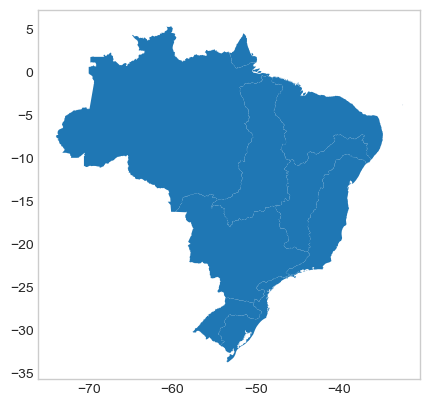

In [71]:
# Combine with the rest of the data
gdf_merged = gpd.GeoDataFrame(
    pd.concat([
        gdf[gdf['fid'].isin([20, 22, 23])].dissolve() # TOCANTINS
        , gdf[gdf['fid'].isin([1, 52])].dissolve() # URUGUAY 
        , gdf[gdf['fid'].isin([42,37,36,39])].dissolve() # SAO FRANCISCO
        , gdf[gdf['fid'].isin([11, 17, 16,19,18,12,13,14,15,41,40,43])].dissolve() # NORTH ATLANTIC REGION
        , gdf[gdf['fid'].isin([30,31,29,28,34,35,32,33,38])].dissolve() # CENTRAL ATLANTIC REGION
        , gdf[gdf['fid'].isin([4,53,5,2,3])].dissolve() # SOUTH ATLANTIC REGION
        , gdf[gdf['fid'].isin([6,7,8,9,10,21,24,25,26,27])].dissolve() # AMAZON RIVER
        , gdf[gdf['fid'].isin([44,45,46,47,48,49,50,51,54])].dissolve() # PARANA RIVER
    ]),
    crs=gdf.crs
)

# Optional: Reset index
gdf_merged = gdf_merged.reset_index(drop=True)
gdf_merged.plot()

In [72]:
gdf_merged

,geometry,fid,id,cd_mesoRH,nm_mesoRH,cd_macroRH,nm_macroRH,area
0,"POLYGON ((-52.84598 -17.70437, -52.84601 -17.7...",23.0,71,10213,Alto Tocantins,102,TOCANTINS-ARAGUAIA,306206.801537
1,"POLYGON ((-54.4521 -31.64075, -54.45193 -31.64...",1.0,158,11045,Alto Uruguai,110,URUGUAI,76620.958014
2,"POLYGON ((-43.68262 -20.43002, -43.68281 -20.4...",39.0,205,10629,Alto São Francisco,106,SÃO FRANCISCO,99460.464209
3,"MULTIPOLYGON (((-43.45876 -9.22555, -43.4594 -...",12.0,282,10420,Alto Parnaíba,104,PARNAÍBA,137081.887020
4,"MULTIPOLYGON (((-44.21522 -23.09143, -44.21484...",32.0,28,10732,Contas,107,ATLÂNTICO LESTE,64678.503197
5,"MULTIPOLYGON (((-53.74671 -32.08401, -53.74745...",53.0,83,10943,Jacuí,109,ATLÂNTICO SUL,84850.732505
6,"MULTIPOLYGON (((-60.45125 -13.88272, -60.45185...",10.0,136,10102,Foz do Amazonas,101,AMAZÔNICA,74369.340834
7,"POLYGON ((-50.25757 -26.85121, -50.25831 -26.8...",46.0,21,11254,Alto Paraguai,112,PARAGUAI,188965.046351


In [73]:
gdf_macroRH = gdf_merged.drop(columns=['fid', 'id', 'cd_mesoRH', 'nm_mesoRH', 'area'])

gdf_macroRH.loc[
    (gdf_merged['cd_macroRH'] == '112') & (gdf_merged['nm_macroRH'] == 'PARAGUAI'),
    ['cd_macroRH', 'nm_macroRH']
] = ['111', 'Parana river']

gdf_macroRH.loc[
    (gdf_merged['nm_macroRH'] == 'TOCANTINS-ARAGUAIA'),
    ['nm_macroRH']
] = ['Tocantins river']

gdf_macroRH.loc[
    (gdf_merged['nm_macroRH'] == 'URUGUAI'),
    ['nm_macroRH']
] = ['Uruguay river']

gdf_macroRH.loc[
    (gdf_merged['nm_macroRH'] == 'SÃO FRANCISCO'),
    ['nm_macroRH']
] = ['Sao Francisco river']

gdf_macroRH.loc[
    (gdf_merged['cd_macroRH'] == '104') & (gdf_merged['nm_macroRH'] == 'PARNAÍBA'),
    ['cd_macroRH', 'nm_macroRH']
] = ['105', 'North Atlantic region']

gdf_macroRH.loc[
    (gdf_merged['nm_macroRH'] == 'ATLÂNTICO LESTE'),
    ['nm_macroRH']
] = ['Central Atlantic region']


gdf_macroRH.loc[
    (gdf_merged['nm_macroRH'] == 'ATLÂNTICO SUL'),
    ['nm_macroRH']
] = ['South Atlantic region']

gdf_macroRH.loc[
    (gdf_merged['nm_macroRH'] == 'AMAZÔNICA'),
    ['nm_macroRH']
] = ['Amazon river']

gdf_macroRH.sort_values(['cd_macroRH'], inplace = True)
gdf_macroRH

,geometry,cd_macroRH,nm_macroRH
6,"MULTIPOLYGON (((-60.45125 -13.88272, -60.45185...",101,Amazon river
0,"POLYGON ((-52.84598 -17.70437, -52.84601 -17.7...",102,Tocantins river
3,"MULTIPOLYGON (((-43.45876 -9.22555, -43.4594 -...",105,North Atlantic region
2,"POLYGON ((-43.68262 -20.43002, -43.68281 -20.4...",106,Sao Francisco river
4,"MULTIPOLYGON (((-44.21522 -23.09143, -44.21484...",107,Central Atlantic region
5,"MULTIPOLYGON (((-53.74671 -32.08401, -53.74745...",109,South Atlantic region
1,"POLYGON ((-54.4521 -31.64075, -54.45193 -31.64...",110,Uruguay river
7,"POLYGON ((-50.25757 -26.85121, -50.25831 -26.8...",111,Parana river


In [74]:
# Calculate area in square meters
gdf_macroRH = gdf_macroRH.to_crs(epsg=31982) 

gdf_macroRH['area_km2'] = gdf_macroRH.geometry.area * 10000 * (8.51/8.695357)

# Convert to square kilometers (optional)
gdf_macroRH['area_km2_10e6'] = gdf_macroRH['area_km2'] / 1_000_000

print(gdf_macroRH['area_km2'].sum())

gdf_macroRH


8.51041705161437e+16


,geometry,cd_macroRH,nm_macroRH,area_km2,area_km2_10e6
6,"MULTIPOLYGON (((-525311.528 8444817.561, -5253...",101,Amazon river,3.808733e+16,3.808733e+10
0,"POLYGON ((304228.481 8041561.736, 304225.799 8...",102,Tocantins river,9.188692e+15,9.188692e+09
3,"MULTIPOLYGON (((1330661.303 8971409.235, 13305...",105,North Atlantic region,9.759384e+15,9.759384e+09
2,"POLYGON ((1264919.499 7723816.993, 1264895.412...",106,Sao Francisco river,6.336519e+15,6.336519e+09
4,"MULTIPOLYGON (((1195979.47 7430145.166, 119601...",107,Central Atlantic region,5.747668e+15,5.747668e+09
5,"MULTIPOLYGON (((240752.194 6446950.38, 240680....",109,South Atlantic region,2.106535e+15,2.106535e+09
1,"POLYGON ((172575.839 6494204.575, 172591.795 6...",110,Uruguay river,1.709649e+15,1.709649e+09
7,"POLYGON ((573758.5 7029828.614, 573685.502 702...",111,Parana river,1.216839e+16,1.216839e+10


In [75]:
# Step 1: Convert df_info to a GeoDataFrame
geometry = [Point(xy) for xy in zip(df_info['long'], df_info['lat'])]
gdf_info = gpd.GeoDataFrame(df_info, geometry=geometry, crs="EPSG:4326")  # Assuming lat/long is in WGS84

# Reproject to match gdf_macroRH's CRS (if necessary)
gdf_info = gdf_info.to_crs(gdf_macroRH.crs)

# Step 2: Perform a spatial join
gdf_basin = gpd.sjoin(gdf_info, gdf_macroRH[['geometry', 'nm_macroRH']], how='left', predicate='within')

# Drop unnecessary columns (e.g., index_right)
gdf_basin = gdf_basin.drop(columns=['index_right'])

In [76]:
gdf_basin = gdf_basin[['gauge_code', 'state', 'nm_macroRH']]
gdf_basin

,gauge_code,state,nm_macroRH
18981,S717,MATO GROSSO DO SUL,Parana river
18980,S716,MATO GROSSO DO SUL,Parana river
18979,S715,MATO GROSSO DO SUL,Parana river
18978,S714,MATO GROSSO DO SUL,Parana river
18977,S713,MATO GROSSO DO SUL,Parana river
...,...,...,...
4,00047005,PARÁ,North Atlantic region
3,00047004,PARÁ,North Atlantic region
2,00047003,PARÁ,North Atlantic region
1,00047002,PARÁ,North Atlantic region


# Numerical Analysis

In [77]:
# Assuming df_data is already loaded with columns: gauge_code, datetime, rain_mm

df_data['datetime'] = pd.to_datetime(df_data['datetime'])
df_data['year'] = df_data['datetime'].dt.year

# Aggregate rain_mm by gauge_code and year
agg_data = df_data.groupby(['gauge_code', 'year'])['rain_mm'].sum().reset_index()

# Pivot to create a heatmap-compatible DataFrame
heatmap_data = agg_data.pivot(index='gauge_code', columns='year', values='rain_mm').fillna(0)
heatmap_data.columns = heatmap_data.columns.astype(str)  

heatmap_data.reset_index(inplace=True)

heatmap_data.columns = heatmap_data.columns.get_level_values(0)
heatmap_data.columns.name = None
heatmap_data.sort_values(['gauge_code'], ascending=False, inplace = True)
heatmap_data = heatmap_data.drop(columns=['gauge_code'])
heatmap_data[heatmap_data > 0] = 1
heatmap_data

,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
18369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
18367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
18366,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
18365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0


In [78]:
column_sums = heatmap_data.sum()

# Step 2: Pivot columns to rows
result = column_sums.reset_index()
result.columns = ['year', 'active_gauges']
result['active_gauges'] = result['active_gauges'].astype(int)
result

,year,active_gauges
0,1961,3321
1,1962,3951
2,1963,4266
3,1964,4461
4,1965,4520
...,...,...
59,2020,3357
60,2021,5830
61,2022,6151
62,2023,6126


In [79]:
result['year'] = result['year'].astype(str)
result['active_gauges'] = result['active_gauges'].astype(int)
result.sort_values(['year'], ascending=True, inplace = True)
result.drop_duplicates(subset=['year'], keep='last', inplace=True)
result

,year,active_gauges
0,1961,3321
1,1962,3951
2,1963,4266
3,1964,4461
4,1965,4520
...,...,...
59,2020,3357
60,2021,5830
61,2022,6151
62,2023,6126


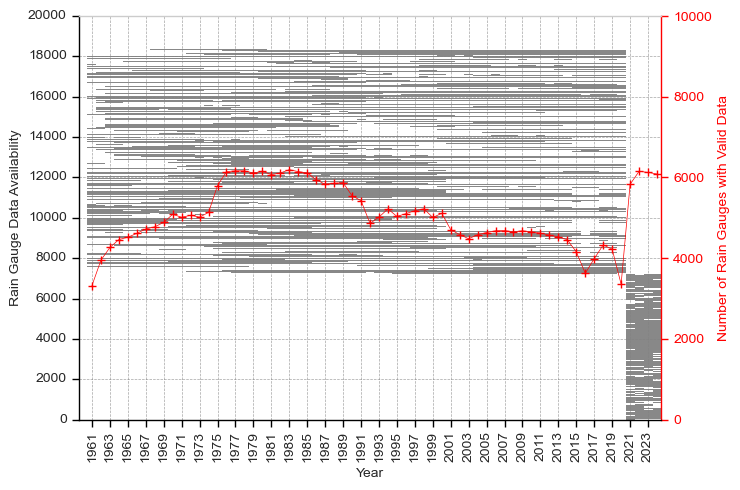

In [80]:
# Exemplo: dados simulados (substitua pelos seus)
# heatmap_data: matriz binária 0-1 (eixos: estações x anos)
# result: DataFrame com colunas 'year' e 'active_gauges'
# years: array com os anos das colunas do heatmap

# Criar colormap: 0 → branco, 1 → cinza
cmap = mcolors.ListedColormap(['white', '#888888'])
cmap.set_over('white')  # Valores >1 também serão brancos

# Criar figura e eixo
fig, ax = plt.subplots(figsize=(7.5, 5))

# Plot do heatmap
sns.heatmap(
    heatmap_data,
    cmap=cmap,
    vmin=0,
    vmax=1,
    linewidths=0,
    linecolor='white',
    cbar=False,
    ax=ax
)

# Eixos do heatmap
ax.set_xlabel('Year')
ax.set_ylabel('Rain Gauge Data Availability')
ax.set_ylim(0, 20000)

# Personalizar ticks do eixo x
ax.tick_params(
    axis='x',
    which='both',
    length=5,
    width=1,
    color='black',
    bottom=True,
    top=False
)

# Personalizar ticks do eixo y
ax.tick_params(
    axis='y',
    which='both',
    left=True,
    right=False,
    labelleft=True,
    labelright=False,
    length=5,
    width=1,
    color='black'
)

ax.set_yticks(np.arange(0, 20001, 2000))
ax.set_yticklabels(np.arange(0, 20001, 2000), rotation=0)

# Segundo eixo y para a linha vermelha
ax2 = ax.twinx()

# Certificar que os anos são inteiros
result['year'] = result['year'].astype(int)
years = result['year'].unique()
years = years.astype(int)

# Alinhar valores da linha vermelha ao centro das colunas do heatmap
year_idx = result['year'] - years.min() + 0.5

# Plot da linha vermelha
ax2.plot(
    year_idx,
    result['active_gauges'],
    color='red',
    marker='+',
    linestyle='-',
    linewidth=0.5,
    label='Active Gauges'
)

# Eixo y direito
ax2.set_ylabel('Number of Rain Gauges with Valid Data', color='red')
ax2.set_ylim(0, 10000)
ax2.set_xlim(-1, len(years))
ax2.tick_params(axis='y', labelcolor='red')

# Ajustar posição do eixo direito
ax2.spines.right.set_position(('axes', 1.00001))
ax2.tick_params(
    axis='y',
    which='both',
    left=False,
    right=True,
    labelleft=False,
    length=5,
    width=1,
    color='red'
)

# Ajustes visuais dos contornos
ax2.spines['left'].set_color('black')
ax2.spines['bottom'].set_color('black')
ax2.spines['right'].set_color('red')
ax2.yaxis.label.set_color('red')

# Grid abaixo dos dados
ax.set_axisbelow(False)
ax.grid(True, axis='both', which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

# Mostrar e salvar
plt.tight_layout()
plt.savefig('./figures/Figure_3_active_stations_per_year_versus_completeness.tiff', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [81]:
result[['year', 'active_gauges']].tail(45)

,year,active_gauges
19,1980,6153
20,1981,6070
21,1982,6111
22,1983,6193
23,1984,6145
24,1985,6112
25,1986,5945
26,1987,5829
27,1988,5858
28,1989,5869


In [82]:
result['active_gauges'].max()

6193

In [83]:
df_basis = pd.merge(agg_data[['gauge_code', 'year']], gdf_basin[['gauge_code', 'nm_macroRH']], on = 'gauge_code', how = 'left')
df_basis

,gauge_code,year,nm_macroRH
0,00047000,1961,North Atlantic region
1,00047000,1962,North Atlantic region
2,00047000,1963,North Atlantic region
3,00047000,1964,North Atlantic region
4,00047002,1977,North Atlantic region
...,...,...,...
345863,S713,2021,Parana river
345864,S714,2021,Parana river
345865,S715,2021,Parana river
345866,S716,2021,Parana river


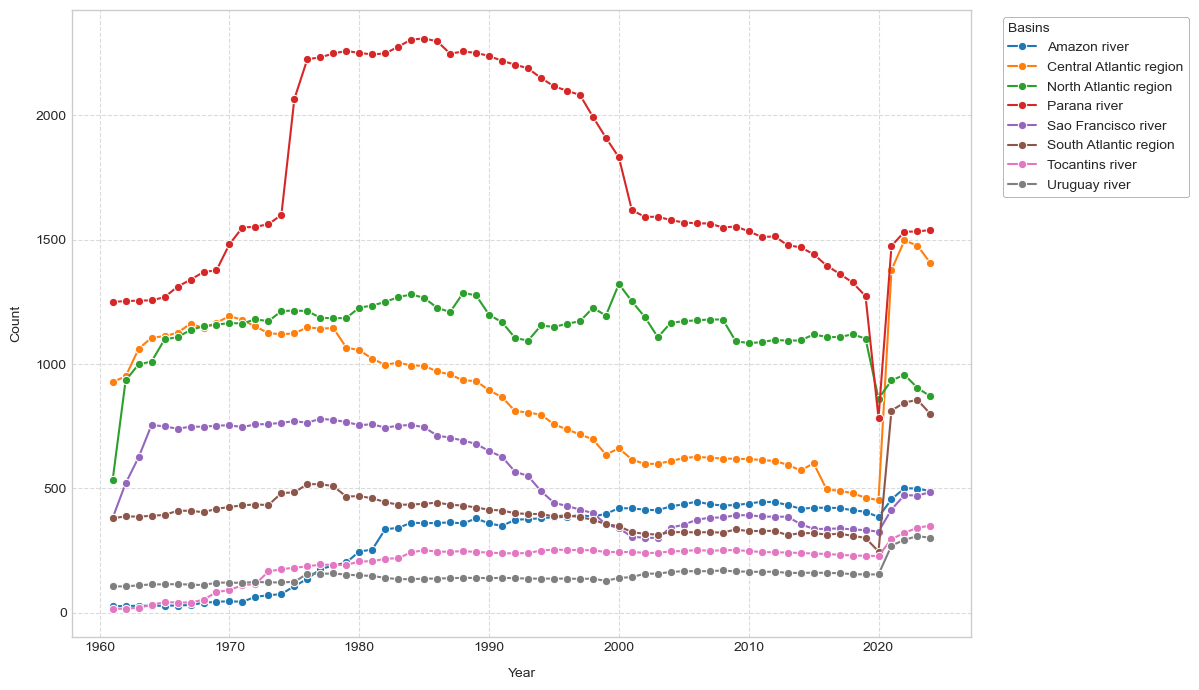

In [84]:
# Aggregate data
df_grouped = df_basis.groupby(['year', 'nm_macroRH'])['gauge_code'].count().reset_index(name='count')

# Create figure and axes
fig, ax = plt.subplots(figsize=(15, 7))

# Plot using seaborn
sns.lineplot(
    data=df_grouped,
    x='year',
    y='count',
    hue='nm_macroRH',
    marker='o',
    palette='tab10',
    ax=ax
)

# Customize the existing legend
legend = ax.get_legend()
if legend:  # Check if legend exists
    # Modify legend properties
    legend.set_title('Basins')
    legend.set_frame_on(True)
    
    # Adjust legend position
    legend._legend_box.align = "left"
    legend.set_bbox_to_anchor((1.25, 1))  # Position outside to the right
    
    # Customize frame appearance
    frame = legend.get_frame()
    frame.set_facecolor('white')
    frame.set_edgecolor('grey')
    frame.set_linewidth(0.5)
else:
    # Create legend if it doesn't exist (safety check)
    ax.legend(title='Basins', bbox_to_anchor=(1.25, 1), loc='upper left')

# Add labels and styling
# ax.set_title('Count of Gauge Codes by Year and Region', pad=20)
ax.set_xlabel('Year', labelpad=10)
ax.set_ylabel('Count', labelpad=10)
ax.grid(True, linestyle='--', alpha=0.7)

# Adjust layout to accommodate external legend
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Make space for right-side legend
plt.show()

In [85]:
df_grouped_amazon = df_grouped[df_grouped['nm_macroRH'] == 'Amazon river']
df_grouped_amazon

,year,nm_macroRH,count
0,1961,Amazon river,26
8,1962,Amazon river,27
16,1963,Amazon river,28
24,1964,Amazon river,28
32,1965,Amazon river,28
...,...,...,...
472,2020,Amazon river,385
480,2021,Amazon river,456
488,2022,Amazon river,501
496,2023,Amazon river,499


In [86]:
# Calculate averages
avg_historical = df_grouped_amazon[
    (df_grouped_amazon['year'] >= 1961) & 
    (df_grouped_amazon['year'] <= 2020)
]['count'].mean()

avg_recent = df_grouped_amazon[
    (df_grouped_amazon['year'] >= 2021) & 
    (df_grouped_amazon['year'] <= 2024)
]['count'].mean()

# Print results with formatting
print(f"Average count (1961-2020): {avg_historical:.1f}")
print(f"Average count (2021-2024): {avg_recent:.1f}")

Average count (1961-2020): 291.0
Average count (2021-2024): 486.2


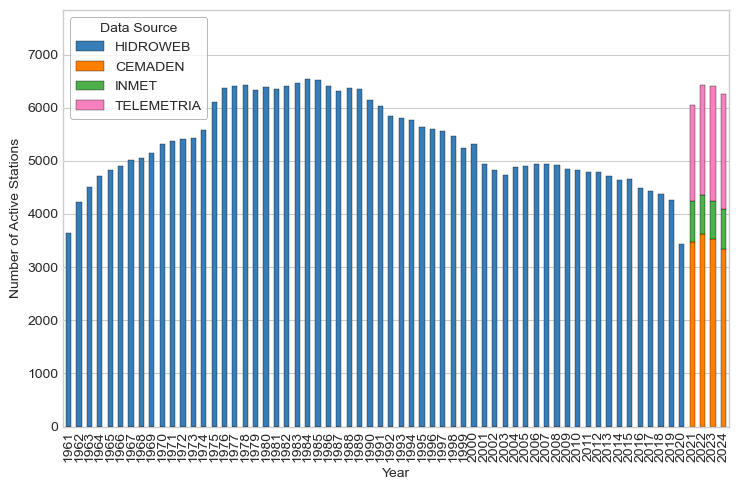

In [87]:
# Group by year and source, and count the number of unique gauge_codes
df_active_gauges = df_complete_info_by_year.groupby(['year', 'source']).agg({'gauge_code': 'nunique'}).reset_index()

# Pivot the dataframe to have years as index and sources as columns
df_pivot = df_active_gauges.pivot(index='year', columns='source', values='gauge_code').fillna(0)
df_pivot = df_pivot[['HIDROWEB', 'CEMADEN', 'INMET', 'TELEMETRIA']]
# df_pivot.replace(0, np.nan, inplace=True)

ax = df_pivot.plot(kind='bar'
                   , stacked=True
                   , figsize=(7.5, 5)
                   , color=['#377eb8', '#ff7f00', '#4daf4a', '#f781bf']
                   , edgecolor = 'black'
                   , linewidth = 0.25)

# Modify the EXISTING legend from pandas plot
legend = ax.get_legend()
legend.set_title('Data Source')  # Set title
legend.set_frame_on(True)  # Ensure frame is visible

# Customize frame properties
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('grey')
frame.set_linewidth(0.5)

# Rest of your plot code
plt.ylim(0, df_active_gauges['gauge_code'].max() * 1.2)
plt.xlabel('Year')
plt.ylabel('Number of Active Stations')
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('./figures/active_stations_per_year.tiff', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

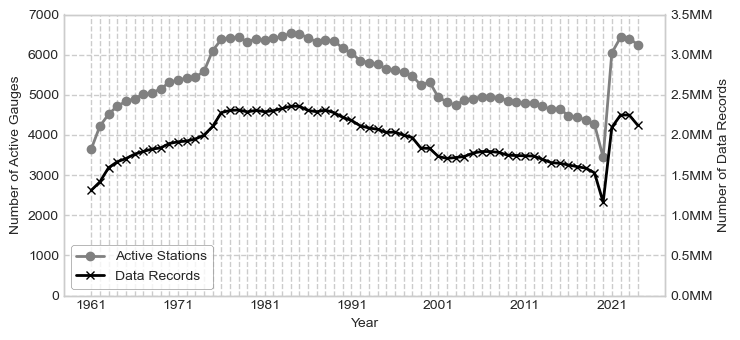

In [88]:
def millions_formatter(x, pos):
    return f'{round(x/1e6,2)}MM'

# Grouping data
stations_per_year = df_complete_info_by_year.groupby('year')['gauge_code'].nunique().reset_index(name='active_stations')
records_per_year = df_complete_info_by_year.groupby('year')['num_days_activity'].sum().reset_index(name='record_count')

# Ensure years are sorted
stations_per_year.sort_values('year', inplace=True)
records_per_year.sort_values('year', inplace=True)

# Set x-tick labels
years = list(range(1961, 2025, 1))  # Years from 1961 to 2024
xticks = years  # Use all years as x-ticks
xticklabels = [str(year) if str(year).endswith('1') else '' for year in years]  # Labels only for years ending in "1"

fig, ax1 = plt.subplots(figsize=(7.5, 3.5))

# Plot active stations
ax1.plot(stations_per_year['year'], stations_per_year['active_stations'], color='grey', marker='o', label='Active Stations', linewidth=2)
ax1.set_xticks(xticks)
ax1.set_xticklabels(xticklabels, rotation=0)
ax1.set_ylim(0, 7000)
ax1.grid(linestyle='--', linewidth=1, axis='both')

# Secondary axis for data records
ax2 = ax1.twinx()
ax2.plot(records_per_year['year'], records_per_year['record_count'], color='black', marker='x', label='Data Records', linewidth=2)
ax2.set_ylim(0, 3500000)
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter))

# Axis labels
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Active Gauges')
ax2.set_ylabel('Number of Data Records')

# Title
# plt.title("Number of Active Stations and Data Records by Year", **tnr_title)
plt.setp(plt.gca().get_xticklabels(), rotation=90)

# Legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
legend = ax2.legend(lines + lines2, labels + labels2, loc='lower left')

# Modify the EXISTING legend from pandas plot
legend.set_frame_on(True)  # Ensure frame is visible

# Customize frame properties
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('grey')
frame.set_linewidth(0.5)

plt.tight_layout()

# Save the figure
plt.savefig('./figures/stations_and_records_by_year_1961_2024.tiff', format='tiff', dpi=300, bbox_inches='tight')

plt.show()
plt.close()

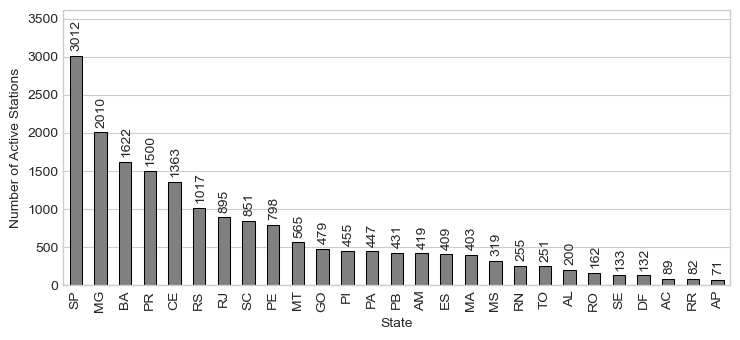

In [89]:
# Group by state_abbreviation and count the number of unique gauge_codes
df_active_stations_by_state = df_complete_info.groupby('state_abbreviation').agg({'gauge_code': 'nunique'}).reset_index().sort_values(by='gauge_code', ascending=False)

# Plot the bar chart
ax = df_active_stations_by_state.plot(kind='bar'
                                      , x='state_abbreviation'
                                      , y='gauge_code'
                                      , figsize=(7.5, 3.5)
                                      , legend=False
                                      , color = 'grey'
                                      , edgecolor = 'black'
                                      , linewidth = 0.75)

# Hide y-axis ticks
# ax.set_yticks([]) 

for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x() + p.get_width() / 10, p.get_height() + 100), rotation=90)

plt.ylim(0, df_active_stations_by_state['gauge_code'].max()*1.20)
plt.xlabel('State')
plt.ylabel('Number of Active Stations')
# plt.title('Number of Active Stations by State')
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('./figures/active_stations_by_state.tiff', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

C:\Users\linde\AppData\Local\Temp\ipykernel_21720\1811151793.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_active_years_count = df_complete_info_general.groupby('active_years_bin').agg({'gauge_code': 'count'}).reset_index()


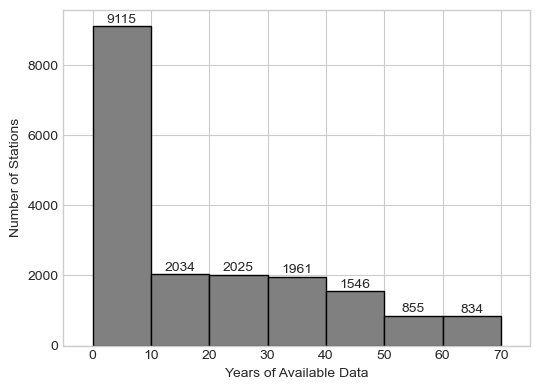

In [90]:
# Create bins for the number of active years
bins = list(range(0, 80, 10))
labels = [f"{i}-{i+10}" for i in bins[:-1]]  # Labels like "0-10", "10-20", etc.

# Bin the 'num_years_activity' column
df_complete_info_general = df_complete_info.copy(deep=True)
df_complete_info_general['active_years_bin'] = pd.cut(
    df_complete_info_general['num_years_activity'], 
    bins=bins, 
    right=False
)

# Group by the bins and count the number of stations
df_active_years_count = df_complete_info_general.groupby('active_years_bin').agg({'gauge_code': 'count'}).reset_index()

# Plot the histogram
fig, ax = plt.subplots(figsize=(5.5, 4))
n, bins, patches = ax.hist(
    df_complete_info_general['num_years_activity'], 
    bins=bins, 
    color='grey', 
    edgecolor='black'
)

# Add labels over columns
for patch, count in zip(patches, df_active_years_count['gauge_code']):
    height = patch.get_height()
    ax.text(
        patch.get_x() + patch.get_width() / 2,  # X position (center of the bar)
        height + 10,  # Y position (slightly above the bar)
        str(count),  # Text to display (count of stations)
        ha='center',  # Horizontal alignment
        va='bottom'  # Vertical alignment
    )

# Adjust plot limits and labels
plt.xlim(-5, 75)
plt.xlabel('Years of Available Data')
plt.ylabel('Number of Stations')
plt.grid(True)
plt.tight_layout()
plt.savefig('./figures/active_years_distribution_general.tiff', dpi=300, bbox_inches='tight')
plt.show()

plt.close()

C:\Users\linde\AppData\Local\Temp\ipykernel_21720\3091889100.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_complete_info_hidroweb['active_years_bin'] = pd.cut(
C:\Users\linde\AppData\Local\Temp\ipykernel_21720\3091889100.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_active_years_count = df_complete_info_hidroweb.groupby('active_years_bin').agg({'gauge_code': 'count'}).reset_index()


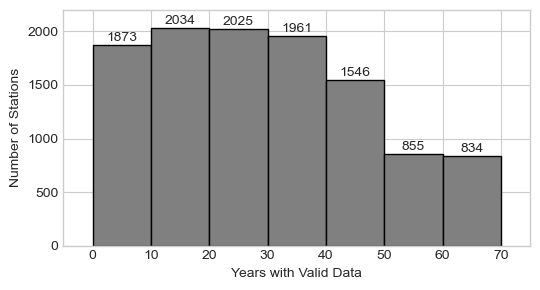

In [91]:
# Create bins for the number of active years
bins = list(range(0, 80, 10))
labels = [f"{i}-{i+10}" for i in bins[:-1]]  # Labels like "0-10", "10-20", etc.

# Bin the 'num_years_activity' column
df_complete_info_hidroweb = df_complete_info[df_complete_info['source']=="HIDROWEB"]
df_complete_info_hidroweb['active_years_bin'] = pd.cut(
    df_complete_info_hidroweb['num_years_activity'], 
    bins=bins, 
    right=False
)

# Group by the bins and count the number of stations
df_active_years_count = df_complete_info_hidroweb.groupby('active_years_bin').agg({'gauge_code': 'count'}).reset_index()

# Plot the histogram
fig, ax = plt.subplots(figsize=(5.5, 3))
n, bins, patches = ax.hist(
    df_complete_info_hidroweb['num_years_activity'], 
    bins=bins, 
    color='grey', 
    edgecolor='black'
)

# Add labels over columns
for patch, count in zip(patches, df_active_years_count['gauge_code']):
    height = patch.get_height()
    ax.text(
        patch.get_x() + patch.get_width() / 2,  # X position (center of the bar)
        height + 10,  # Y position (slightly above the bar)
        str(count),  # Text to display (count of stations)
        ha='center',  # Horizontal alignment
        va='bottom'  # Vertical alignment
    )

# Adjust plot limits and labels
plt.xlim(-5, 75)
plt.ylim(None, 2200)
plt.xlabel('Years with Valid Data')
plt.ylabel('Number of Stations')
plt.grid(True)
plt.tight_layout()
plt.savefig('./figures/active_years_distribution_hidroweb.tiff', dpi=300, bbox_inches='tight')
plt.show()

plt.close()

C:\Users\linde\AppData\Local\Temp\ipykernel_21720\1948702680.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_active_years_count_subdaily = df_complete_info_subdaily.groupby('active_years_bin').agg({'gauge_code': 'count'}).reset_index()


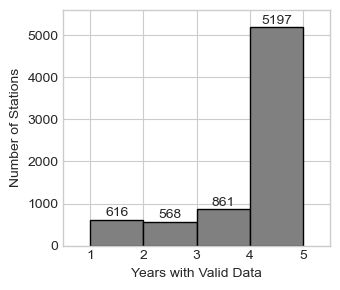

In [92]:
# Create bins for the number of active years
bins = list(range(1, 6, 1))
labels = [f"{i}-{i+1}" for i in bins[:-1]]  # Labels like "0-10", "10-20", etc.

# Bin the 'num_years_activity' column
df_complete_info_subdaily = df_complete_info[df_complete_info['source']!="HIDROWEB"].copy(deep=True)
df_complete_info_subdaily['active_years_bin'] = pd.cut(
    df_complete_info_subdaily['num_years_activity'], 
    bins=bins, 
    right=False
)

# Group by the bins and count the number of stations
df_active_years_count_subdaily = df_complete_info_subdaily.groupby('active_years_bin').agg({'gauge_code': 'count'}).reset_index()

# Plot the histogram
fig, ax = plt.subplots(figsize=(3.5, 3))
n, bins, patches = ax.hist(
    df_complete_info_subdaily['num_years_activity'], 
    bins=bins, 
    color='grey', 
    edgecolor='black'
)

# Add labels over columns
for patch, count in zip(patches, df_active_years_count_subdaily['gauge_code']):
    height = patch.get_height()
    ax.text(
        patch.get_x() + patch.get_width() / 2,  # X position (center of the bar)
        height + 10,  # Y position (slightly above the bar)
        str(count),  # Text to display (count of stations)
        ha='center',  # Horizontal alignment
        va='bottom'  # Vertical alignment
    )

plt.ylim(None, 5600)

# Adjust plot limits and labels
plt.xlim(0.5, 5.5)
plt.xlabel('Years with Valid Data')
plt.ylabel('Number of Stations')
plt.grid(True)
plt.tight_layout()
plt.savefig('./figures/active_years_distribution_subdaily.tiff', dpi=300, bbox_inches='tight')
plt.show()

plt.close()

In [93]:
df_active_years_count_subdaily

,active_years_bin,gauge_code
0,"[1, 2)",616
1,"[2, 3)",568
2,"[3, 4)",861
3,"[4, 5)",5197


C:\Users\linde\AppData\Local\Temp\ipykernel_21720\2318075759.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_hidroweb = hidroweb.groupby('active_years_bin').agg({'gauge_code': 'count'}).reset_index()
C:\Users\linde\AppData\Local\Temp\ipykernel_21720\2318075759.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_subdaily = subdaily.groupby('active_years_bin').agg({'gauge_code': 'count'}).reset_index()


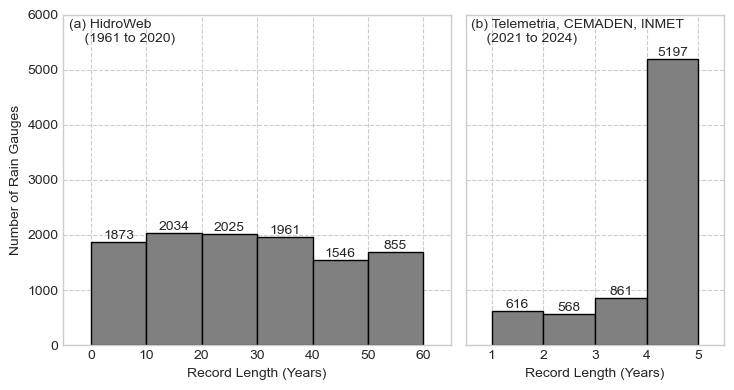

In [94]:
# Criar bins
bins_hidroweb = list(range(0, 61, 10))
bins_subdaily = list(range(1, 6, 1))

# Filtrar dados
hidroweb = df_complete_info[df_complete_info['source'] == "HIDROWEB"].copy()
subdaily = df_complete_info[df_complete_info['source'] != "HIDROWEB"].copy()

# Criar colunas de bins
hidroweb['active_years_bin'] = pd.cut(hidroweb['num_years_activity'], bins=bins_hidroweb, right=False)
subdaily['active_years_bin'] = pd.cut(subdaily['num_years_activity'], bins=bins_subdaily, right=False)

# Contagem de estações
count_hidroweb = hidroweb.groupby('active_years_bin').agg({'gauge_code': 'count'}).reset_index()
count_subdaily = subdaily.groupby('active_years_bin').agg({'gauge_code': 'count'}).reset_index()

# Criar subplots lado a lado
fig, axes = plt.subplots(1, 2, figsize=(7.5, 4), gridspec_kw={'width_ratios': [6, 4]}, sharey=True)

# Histograma HIDROWEB
n, bins, patches = axes[0].hist(hidroweb['num_years_activity'], bins=bins_hidroweb, color='grey', edgecolor='black')
for patch, count in zip(patches, count_hidroweb['gauge_code']):
    axes[0].text(patch.get_x() + patch.get_width() / 2, patch.get_height() + 50, str(count), ha='center')
axes[0].set_xlim(-5, 65)
axes[0].set_ylim(0, 6000)
axes[0].set_xlabel('Record Length (Years)')
axes[0].set_ylabel('Number of Rain Gauges')
# axes[0].set_title('a) HIDROWEB', loc = 'left')
axes[0].grid(True)

# Histograma Subdaily
n, bins, patches = axes[1].hist(subdaily['num_years_activity'], bins=bins_subdaily, color='grey', edgecolor='black')
for patch, count in zip(patches, count_subdaily['gauge_code']):
    axes[1].text(patch.get_x() + patch.get_width() / 2, patch.get_height() + 50, str(count), ha='center')
axes[1].set_xlim(0.5, 5.5)
axes[1].set_ylim(0, 6000)
axes[1].set_xlabel('Record Length (Years)')
# axes[1].set_title('b) TELEMETRIA, CEMADEN, INMET', loc = 'left')
axes[1].grid(True)

for ax, letter, position in zip(axes, ["(a) HidroWeb\n    (1961 to 2020)", "(b) Telemetria, CEMADEN, INMET\n    (2021 to 2024)"], [[-4, 5500],[0.6, 5500]]):
    ax.grid(True, linestyle='--')
    ax.text(position[0], position[1], letter, fontsize=10)

plt.grid(True)
plt.tight_layout()
plt.savefig('./figures/Figure_2_active_years_distribution_subdaily_daily.tiff', dpi=300, bbox_inches='tight')
plt.show()

plt.close()

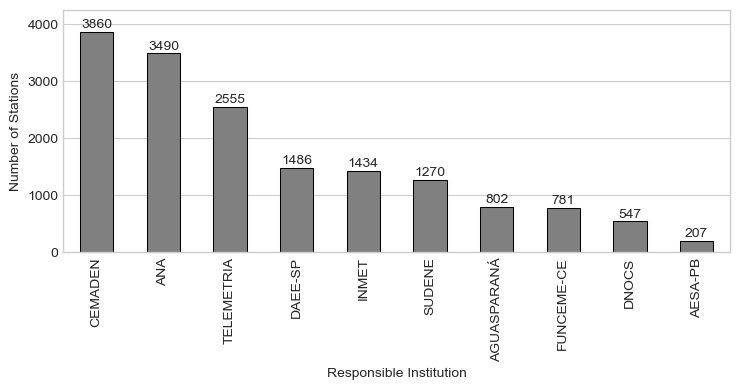

In [95]:
df_gauge_count_by_responsible = df_complete_info.groupby('responsible').agg({'gauge_code': 'nunique'}).reset_index().sort_values(by='gauge_code', ascending=False)
# Filter the dataframe to include only those responsibles with a count greater than 200
df_filtered = df_gauge_count_by_responsible[df_gauge_count_by_responsible['gauge_code'] > 200]

# Plot the bar chart
ax = df_filtered.plot(kind='bar', x='responsible', y='gauge_code', figsize=(7.5, 4), legend=False, color='grey', edgecolor='black', linewidth=0.75)

# Add labels over columns
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x() + p.get_width() / 2, p.get_height() + 10), ha='center', va='bottom')

# Customize plot
plt.ylim(0, df_filtered['gauge_code'].max() * 1.1)
plt.xlabel('Responsible Institution')
plt.ylabel('Number of Stations')
# plt.title('Count of Stations by Responsible (Total Count > 200)')
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('./figures/stations_by_responsible.tiff', dpi=300, bbox_inches='tight')
plt.show()

plt.close()

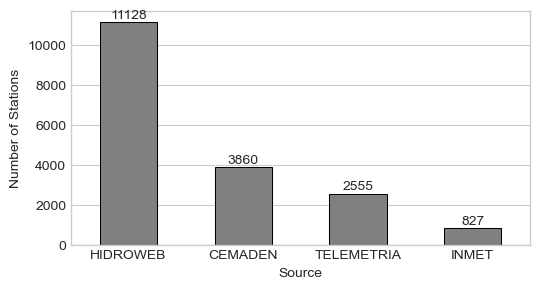

In [96]:
# Group by source and count the number of unique gauge_codes
df_gauge_count_by_source = df_complete_info.groupby('source').agg({'gauge_code': 'nunique'}).reset_index().sort_values(by='gauge_code', ascending=False)

# Plot the bar chart
ax = df_gauge_count_by_source.plot(kind='bar', x='source', y='gauge_code', figsize=(5.5, 3), legend=False, color='grey', edgecolor='black', linewidth=0.75)

# Add labels over columns
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x() + p.get_width() / 2, p.get_height() + 50), ha='center', va='bottom')

# Customize plot
plt.xlabel('Source')
ax.tick_params(axis='x', rotation=0)
plt.ylabel('Number of Stations')
plt.grid(axis='y')
plt.tight_layout()

plt.savefig('./figures/stations_by_source.tiff', dpi=300, bbox_inches='tight')
plt.show()

plt.close()

# SPATIAL ANALYSIS

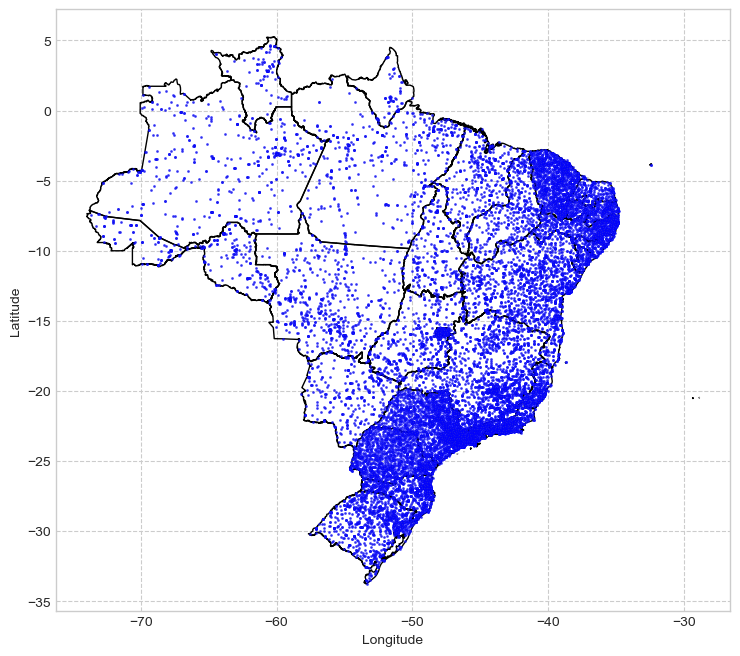

In [97]:
# Load the Brazilian states shapefile
brazil_states = geobr.read_state(year=2020)

# Create a GeoDataFrame for the stations
gdf_stations = gpd.GeoDataFrame(
    df_complete_info,
    geometry=gpd.points_from_xy(df_complete_info.long, df_complete_info.lat),
    crs="EPSG:4326"
)

# Plot the map
fig, ax = plt.subplots(figsize=(7.5, 7))
brazil_states.plot(ax=ax, edgecolor='black', facecolor='none')
gdf_stations.plot(ax=ax, color='grey', edgecolor='blue', markersize=1, alpha=0.7)

# Customize the plot
# plt.title('Stations Over Brazilian Map with State Borders')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, ls = '--')
plt.tight_layout()

# Show the plot
plt.savefig('./figures/stations_over_brazil_map.tiff', dpi=300, bbox_inches='tight')
plt.show()

plt.close()

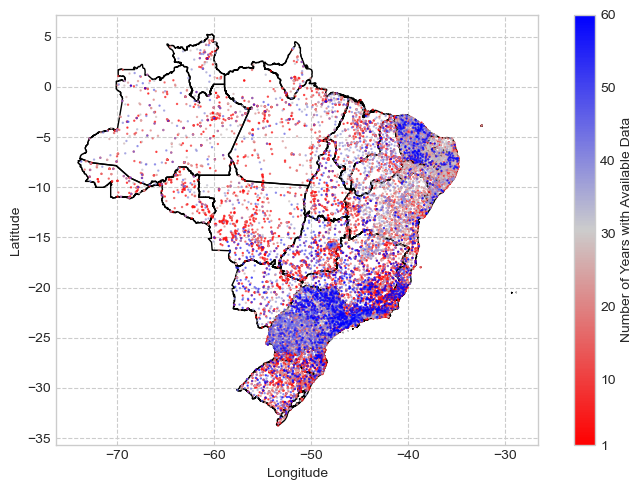

In [98]:
# Define custom colormap
colors = [(1, 0, 0), (0.8, 0.8, 0.8), (0, 0, 1)]  # RGB values
positions = [0, 0.5, 1]  # Color positions from 0 to 1

custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', list(zip(positions, colors)))

# Load the Brazilian states shapefile
brazil_states = geobr.read_state(year=2020)

# Create a GeoDataFrame for the stations
gdf_stations = gpd.GeoDataFrame(
    df_complete_info,
    geometry=gpd.points_from_xy(df_complete_info.long, df_complete_info.lat),
    crs="EPSG:4326"
)

gdf_stations.sort_values(by="num_years_activity", ascending=True, inplace=True)

# Plot the map
fig, ax = plt.subplots(figsize=(7.5, 5))
brazil_states.plot(ax=ax, edgecolor='black', facecolor='none')
gdf_stations.plot(ax=ax
                  , cmap = custom_cmap
                  , s = 0.5
                  , legend = False
                  , column = 'num_years_activity'
                  , alpha = 0.7)

cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(1, 60), cmap=custom_cmap),
             ax=ax, orientation='vertical', label='Number of Years with Available Data')

cbar.set_ticks([1] + list(cbar.get_ticks()[1:]))

# Customize the plot
# plt.title('Stations Over Brazilian Map with State Borders')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, ls = '--')
plt.tight_layout()



# Show the plot
plt.savefig('./figures/Figure_5_stations_over_brazil_map_by_active_years.tiff', dpi=300, bbox_inches='tight')
plt.show()

plt.close()

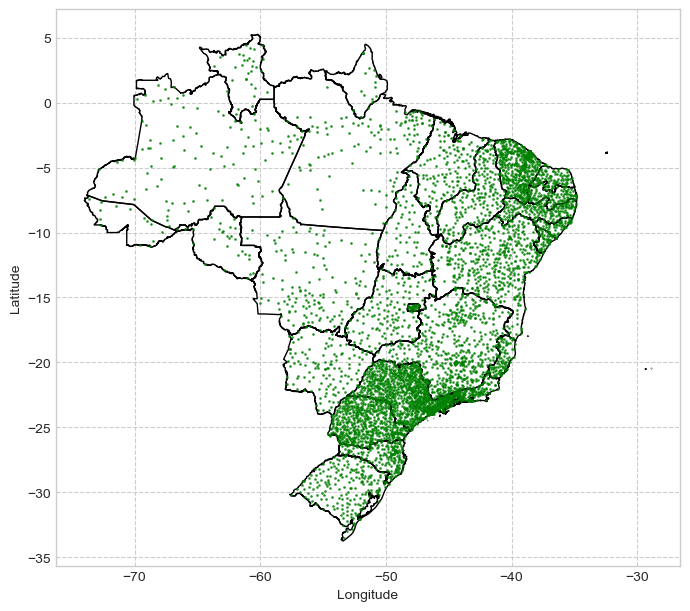

In [99]:

# Filter stations with 60 or more active years
gdf_stations_30_years = gdf_stations[gdf_stations['num_years_activity'] >= 30]

# Plot the map
fig, ax = plt.subplots(figsize=(7, 7))
brazil_states.plot(ax=ax, edgecolor='black', facecolor='none')
gdf_stations_30_years.plot(ax=ax, color='g', markersize=1, alpha=0.7)

# Customize the plot
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, ls='--')
plt.tight_layout()

# Show the plot
plt.savefig('./figures/stations_30_years_or_more.tiff', dpi=300, bbox_inches='tight')
plt.show()

plt.close()

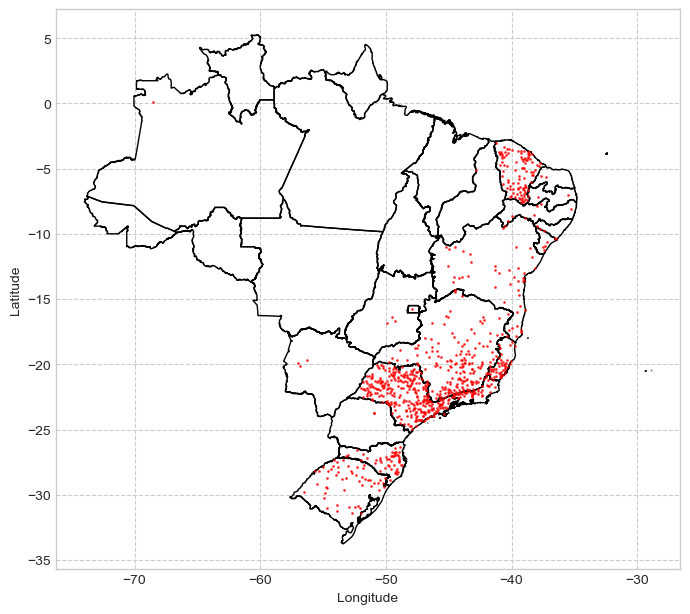

In [100]:
# Filter stations with 60 or more active years
gdf_stations_60_years = gdf_stations[gdf_stations['num_years_activity'] >= 60]

# Plot the map
fig, ax = plt.subplots(figsize=(7, 7))
brazil_states.plot(ax=ax, edgecolor='black', facecolor='none')
gdf_stations_60_years.plot(ax=ax, color='red', markersize=1, alpha=0.7)

# Customize the plot
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, ls='--')
plt.tight_layout()

# Show the plot
plt.savefig('./figures/stations_60_years_or_more.tiff', dpi=300, bbox_inches='tight')
plt.show()

plt.close()

In [101]:
# # Load the Brazilian states shapefile
# brazil_states = geobr.read_state(year=2020)

# # Convert the CRS to a projected coordinate system to calculate the area accurately
# brazil_states = brazil_states.to_crs(epsg=5880)  # EPSG:5880 is a projected CRS for Brazil fixing area 

# brazil_states['area_km2'] = (brazil_states['geometry'].area / 1e6 ).round(0) # Convert area to km²

# brazil_states = brazil_states.to_crs(crs="EPSG:4326") #fix latitudes and longitudes

# df_gauge_count = df_complete_info.groupby('state_abbreviation').agg({
#     'gauge_code': 'nunique'
# }).reset_index()

# df_area_per_station_by_state = pd.merge(
#     brazil_states,
#     df_gauge_count,
#     left_on='abbrev_state',
#     right_on='state_abbreviation'
# )

# df_area_per_station_by_state['area_per_station_km2'] = (df_area_per_station_by_state['area_km2'] / df_area_per_station_by_state['gauge_code']).round(0).astype(int)

# # Plot the map
# fig, ax = plt.subplots(1, 1, figsize=(5.5, 7))

# # brazil_states.boundary.plot(ax=ax, linewidth=1)
# df_area_per_station_by_state = gpd.GeoDataFrame(df_area_per_station_by_state, geometry='geometry')
# df_area_per_station_by_state.plot(ax = ax
#                     , edgecolor = 'white'
#                     , column = 'area_per_station_km2'
#                     , legend = True
#                     , cmap = 'coolwarm'
#                     , alpha = 0.70
#                     , legend_kwds={'orientation': 'horizontal'
#                                    , 'pad': 0.075
#                                    , 'shrink': 0.99
#                                    , 'label': 'Gauge density (area in km² per gauge)'}
#                    )
# # Add labels to the points
# for x, y, label in zip(df_area_per_station_by_state.centroid.x, df_area_per_station_by_state.centroid.y, df_area_per_station_by_state['area_per_station_km2']):
#    ax.annotate(label, xy=(x, y), xytext=(-7, -3), textcoords="offset points", color = "black",  rotation=0)

# plt.xlim(-75,-34)
# plt.ylim(-34,6)

# # plt.title('Area per Station by State in Brazil')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.grid(True, linestyle='--')
# plt.tight_layout()
# plt.savefig('./figures/area_per_station_by_state.tiff', dpi=300, bbox_inches='tight')
# plt.show()
# plt.close()

In [102]:
# brazil_states = brazil_states.to_crs(crs="EPSG:4326")

# # Count unique gauge_code by state_abbreviation
# unique_counts = df_complete_info.groupby('state_abbreviation')['gauge_code'].nunique().reset_index()
# # Rename columns for clarity
# unique_counts.columns = ['state_abbreviation', 'unique_gauge_count']

# df_station_count_by_state = pd.merge(
#     brazil_states,
#     unique_counts,
#     left_on='abbrev_state',
#     right_on='state_abbreviation'
# )


# # Plot the map
# fig, ax = plt.subplots(1, 1, figsize=(5.5, 7))

# # brazil_states.boundary.plot(ax=ax, linewidth=1)
# df_station_count_by_state = gpd.GeoDataFrame(df_station_count_by_state, geometry='geometry')
# df_station_count_by_state.plot(ax = ax
#                     , edgecolor = 'white'
#                     , column = 'unique_gauge_count'
#                     , legend = True
#                     , cmap = 'coolwarm_r'
#                     , alpha = 0.70
#                     , legend_kwds={'orientation': 'horizontal'
#                                    , 'pad': 0.075
#                                    , 'shrink': 0.99
#                                    , 'label': 'Number of gauges'}
#                    )
# # Add labels to the points
# for x, y, label in zip(df_station_count_by_state.centroid.x
#                        , df_station_count_by_state.centroid.y
#                        , df_station_count_by_state['unique_gauge_count']):
#    ax.annotate(label, xy=(x, y), xytext=(-7, -3), textcoords="offset points", color = "black",  rotation=0)

# plt.xlim(-75,-34)
# plt.ylim(-34,6)

# # plt.title('Area per Station by State in Brazil')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.grid(True, linestyle='--')
# plt.tight_layout()
# plt.savefig('./figures/station_count_by_state.tiff', dpi=300, bbox_inches='tight')
# plt.show()
# plt.close()

In [103]:
# # Ensure both datasets use the same CRS
# brazil_states = geobr.read_state(year=2020)
# brazil_states = brazil_states.to_crs(epsg=5880)

# # Calculate area in km²
# brazil_states['area_km2'] = (brazil_states['geometry'].area / 1e6).round(0)

# # Convert back to geographic coordinates
# brazil_states = brazil_states.to_crs(crs="EPSG:4326")

# # Gauge density calculation
# df_gauge_count = df_complete_info.groupby('state_abbreviation').agg({'gauge_code': 'nunique'}).reset_index()
# df_area_per_station_by_state = pd.merge(brazil_states, df_gauge_count, left_on='abbrev_state', right_on='state_abbreviation')
# df_area_per_station_by_state['area_per_station_km2'] = (df_area_per_station_by_state['area_km2'] / df_area_per_station_by_state['gauge_code']).round(0).astype(int)

# # Gauge count calculation
# unique_counts = df_complete_info.groupby('state_abbreviation')['gauge_code'].nunique().reset_index()
# unique_counts.columns = ['state_abbreviation', 'unique_gauge_count']
# df_station_count_by_state = pd.merge(brazil_states, unique_counts, left_on='abbrev_state', right_on='state_abbreviation')

# # Create combined plot
# fig, axs = plt.subplots(2, 1, figsize=(7.5, 10), sharex=True, sharey=True)

# # First map: Area per station (density)
# df_area_per_station_by_state.plot(
#     ax=axs[0],
#     edgecolor='white',
#     column='area_per_station_km2',
#     legend=True,
#     cmap='coolwarm',
#     alpha=0.7,
#     legend_kwds={
#         # 'pad': 0.05,
#         'shrink': 0.95,
#         'label': 'Average Gauge Density (area in km² per gauge)'
#     }
# )
# for x, y, label in zip(df_area_per_station_by_state.centroid.x, df_area_per_station_by_state.centroid.y, df_area_per_station_by_state['area_per_station_km2']):
#     axs[0].annotate(label, xy=(x, y), xytext=(-7, -3), textcoords="offset points", color="black", rotation=0)

# # axs[0].set_title('Gauge Density by State in Brazil')
# # axs[0].set_xlabel('Longitude')
# axs[0].set_ylabel('Latitude')

# # Second map: Number of gauges
# df_station_count_by_state.plot(
#     ax=axs[1],
#     edgecolor='white',
#     column='unique_gauge_count',
#     legend=True,
#     cmap='coolwarm_r',
#     alpha=0.7,
#     legend_kwds={
#         # 'pad': 0.085,
#         'shrink': 0.95,
#         'label': 'Number of Gauges'
#     }
# )
# for x, y, label in zip(df_station_count_by_state.centroid.x, df_station_count_by_state.centroid.y, df_station_count_by_state['unique_gauge_count']):
#     axs[1].annotate(label, xy=(x, y), xytext=(-7, -3), textcoords="offset points", color="black", rotation=0)

# # axs[1].set_title('Number of Gauges by State in Brazil')
# axs[1].set_xlabel('Longitude')
# axs[1].set_ylabel('Latitude')

# for ax, letter in zip(axs, ["a)", "b)"]):
#     ax.set_xlim(-75, -34)
#     ax.set_ylim(-34, 6)
#     ax.grid(True, linestyle='--')
#     ax.text(-74, 4, letter, fontsize=12)

# plt.tight_layout()
# plt.savefig('./figures/combined_gauge_maps_figure_4.tiff', dpi=300, bbox_inches='tight')
# plt.show()
# plt.close()

In [ ]:
norm1 = mcolors.Normalize(vmin=0, vmax=4000)
norm2 = mcolors.Normalize(vmin=0, vmax=3000)

C:\Users\linde\AppData\Local\Temp\ipykernel_21720\1446494014.py:40: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(df_area_per_station_by_state.centroid.x, df_area_per_station_by_state.centroid.y, df_area_per_station_by_state['area_per_station_km2']):
C:\Users\linde\AppData\Local\Temp\ipykernel_21720\1446494014.py:63: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(df_station_count_by_state.centroid.x, df_station_count_by_state.centroid.y, df_station_count_by_state['unique_gauge_count']):


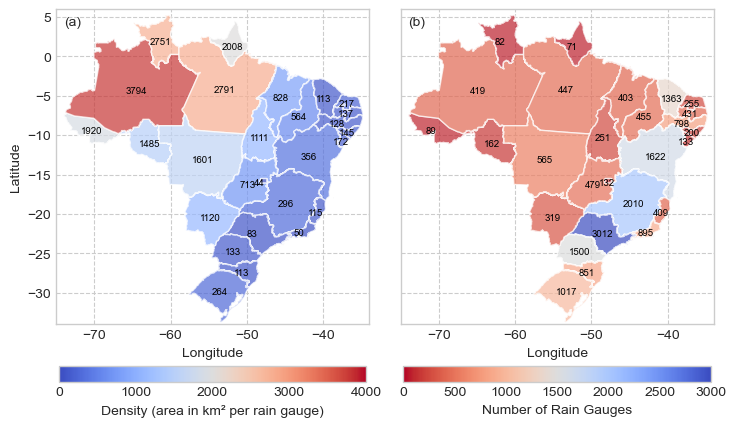

In [110]:
# Ensure both datasets use the same CRS
brazil_states = geobr.read_state(year=2020)
brazil_states = brazil_states.to_crs(epsg=5880)

# Calculate area in km²
brazil_states['area_km2'] = (brazil_states['geometry'].area / 1e6).round(0)

# Convert back to geographic coordinates
brazil_states = brazil_states.to_crs(crs="EPSG:4326")

# Gauge density calculation
df_gauge_count = df_complete_info.groupby('state_abbreviation').agg({'gauge_code': 'nunique'}).reset_index()
df_area_per_station_by_state = pd.merge(brazil_states, df_gauge_count, left_on='abbrev_state', right_on='state_abbreviation')
df_area_per_station_by_state['area_per_station_km2'] = (df_area_per_station_by_state['area_km2'] / df_area_per_station_by_state['gauge_code']).round(0).astype(int)

# Gauge count calculation
unique_counts = df_complete_info.groupby('state_abbreviation')['gauge_code'].nunique().reset_index()
unique_counts.columns = ['state_abbreviation', 'unique_gauge_count']
df_station_count_by_state = pd.merge(brazil_states, unique_counts, left_on='abbrev_state', right_on='state_abbreviation')

# Create combined plot
fig, axs = plt.subplots(1, 2, figsize=(7.5, 4.5), sharex=True, sharey=True)

# First map: Area per station (density)
df_area_per_station_by_state.plot(
    ax=axs[0],
    edgecolor='white',
    column='area_per_station_km2',
    legend=True,
    cmap='coolwarm',
    norm = norm1,
    alpha=0.7,
    legend_kwds={
        'pad': 0.1,
        'shrink': 0.95,
        'label': 'Density (area in km² per rain gauge)',
        'orientation': 'horizontal'
    }
)
for x, y, label in zip(df_area_per_station_by_state.centroid.x, df_area_per_station_by_state.centroid.y, df_area_per_station_by_state['area_per_station_km2']):
    axs[0].annotate(label, xy=(x, y), xytext=(-7, -3), textcoords="offset points", color="black", rotation=0, fontsize=7)

# axs[0].set_title('Gauge Density by State in Brazil')
axs[0].set_xlabel('Longitude')
axs[0].set_ylabel('Latitude')

# Second map: Number of gauges
df_station_count_by_state.plot(
    ax=axs[1],
    edgecolor='white',
    column='unique_gauge_count',
    legend=True,
    cmap='coolwarm_r',
    norm = norm2,
    alpha=0.7,
    legend_kwds={
        'pad': 0.1,
        'shrink': 0.95,
        'label': 'Number of Rain Gauges',
        'orientation': 'horizontal'
    }
)
for x, y, label in zip(df_station_count_by_state.centroid.x, df_station_count_by_state.centroid.y, df_station_count_by_state['unique_gauge_count']):
    axs[1].annotate(label, xy=(x, y), xytext=(-7, -3), textcoords="offset points", color="black", rotation=0, fontsize=7)

# axs[1].set_title('Number of Gauges by State in Brazil')
axs[1].set_xlabel('Longitude')

for ax, letter in zip(axs, ["(a)", "(b)"]):
    ax.set_xlim(-75, -34)
    ax.set_ylim(-34, 6)
    ax.grid(True, linestyle='--')
    ax.text(-74, 4, letter)

plt.tight_layout()
plt.savefig('./figures/Figure_4_combined_gauge_maps_figure_4_horizontal.tiff', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
# # Load the Brazilian states shapefile
# brazil_states = geobr.read_state(year=2020)

# # Ensure datetime is in datetime format
# df_data['datetime'] = pd.to_datetime(df_data['datetime'])

# # Get unique years from the data
# years = df_data['year'].unique()

# # Create a GeoDataFrame for the stations
# gdf_stations = gpd.GeoDataFrame(
#     df_complete_info,
#     geometry=gpd.points_from_xy(df_complete_info.long, df_complete_info.lat),
#     crs="EPSG:4326"
# )

# # Plot stations for each year
# for year in years[:]:
#     # Filter stations for the current year
#     stations_year = df_data[df_data['year'] == year]['gauge_code'].unique()
#     gdf_stations_year = gdf_stations[gdf_stations['gauge_code'].isin(stations_year)]
    
#     # Plot the map
#     fig, ax = plt.subplots(figsize=(7, 7))
#     brazil_states.plot(ax=ax, edgecolor='black', facecolor='none')
#     gdf_stations_year.plot(ax=ax, color='blue', markersize=2, alpha=0.7)
    
#     # Customize the plot
#     plt.title(f'{year}')
#     plt.xlabel('Longitude')
#     plt.ylabel('Latitude')
#     plt.grid(True, ls='--')
#     plt.tight_layout()

#     plt.savefig('./figures/stations_'+str(year)+'.tiff', format='tiff', dpi=300, transparent=False, bbox_inches='tight')
    
    
#     # Show the plot
#     plt.show()
#     plt.close()